# Working with Arrays

## Image Processing

### Image Processing in NumPy

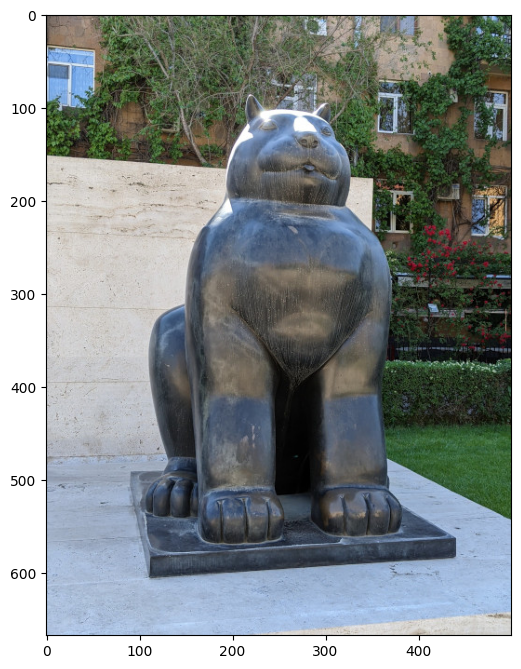

In [ ]:
# Load an image
import numpy as np
from scipy.signal import convolve2d

from matplotlib import pyplot as plt
from skimage.io import imread, imsave
from skimage.util import img_as_float32, img_as_ubyte, random_noise

img = imread('The_Cat.jpg')

from matplotlib import pyplot as plt
plt.figure(figsize = (6, 10))
plt.imshow(img)

In [ ]:
type(img)

numpy.ndarray

In [ ]:
img.ndim

3

In [ ]:
img.shape

(667, 500, 3)

### Tensor Layouts In Memory: NCHW vs. NHWC.
- Image tensors are usually represented in memory in two common formats: NCHW or NHWC. These uppercase letters encode tensor axis semantics, where N stands for batch dimension, C for channel dimension, H for height, and W for width. A tensor described this way contains a batch composed of N images of C color channels, each with height H and width W. It’s problematic to have objects of different sizes in a batch, but special data structures, such as ragged tensors, can do it. Another option is to pad different objects to the same size with some placeholder element.

- Different frameworks and libraries prefer different formats. JAX (https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.conv_general_dilated.html) and PyTorch (https://discuss.pytorch.org/t/why-does-pytorch-prefer-using-nchw/83637/4) use NCHW by default. TensorFlow (https://www.tensorflow.org/api_docs/python/tf/nn/conv2d), Flax (https://flax.readthedocs.io/en/latest/api_reference/_autosummary/flax.linen.Conv.html#flax.linen.Conv) and Haiku (https://dm-haiku.readthedocs.io/en/latest/api.html#haiku.Conv2D) uses NHWC, and almost any library has some function to convert between these formats or a parameter specifying what type of an image tensor is being passed to a function.

- From the mathematical point of view, these representations are equivalent, but from the practical point of view, there may be a difference. For example, convolutions implemented in NVIDIA Tensor Cores require NHWC layout and work faster when input tensors are laid out in the NHWC format (https://docs.nvidia.com/deeplearning/performance/dl-performance-convolutional/index.html#tensor-layout).

In [ ]:
img.size

1000500

In [ ]:
img.nbytes

1000500

In [ ]:
# Slicing NumPy arrays
cat_face = img[80:220, 190:330, 1]
cat_face.shape

(140, 140)

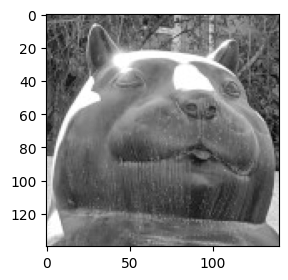

In [ ]:
plt.figure(figsize = (3,4))
plt.imshow(cat_face, cmap='gray')

In [ ]:
# Converting image pixel values to flaot32
img.dtype

dtype('uint8')

In [ ]:
img = img_as_float32(img)
img.dtype

dtype('float32')

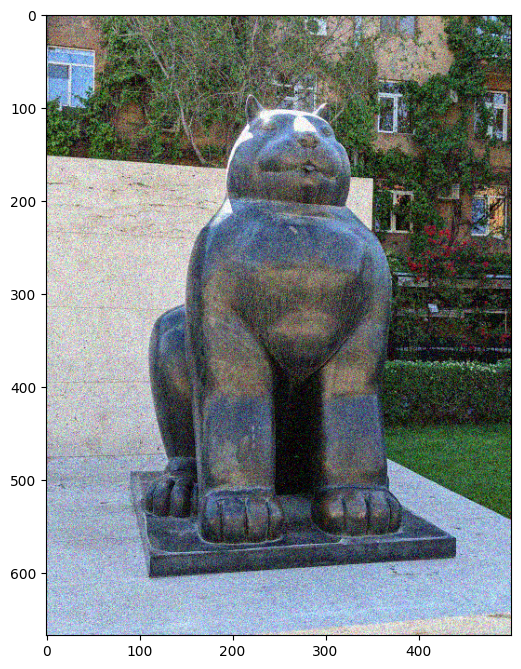

In [ ]:
# Generating a noise version of image
img_noised = random_noise(img, mode='gaussian')
plt.figure(figsize = (6, 10))
plt.imshow(img_noised)

In [ ]:
# Matrix for a simple blur gilter
kernel_blur = np.ones((5,5))
kernel_blur /= np.sum(kernel_blur)
kernel_blur

array([[0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04]])

In [ ]:
# Creating a gaussian blur(more involved version of simple blur)
def gaussian_kernel(kernel_size, sigma=1.0, mu=0.0):
    """ A function to generate Gaussian 2D kernel """
    center = kernel_size // 2
    x, y = np.mgrid[
        -center : kernel_size - center,
        -center : kernel_size - center]
    d = np.sqrt(np.square(x) + np.square(y))
    koeff = 1 / (2 * np.pi * np.square(sigma))
    kernel = koeff * np.exp(-np.square(d-mu) / (2 * np.square(sigma)))
    return kernel

kernel_gauss = gaussian_kernel(5)
kernel_gauss

array([[0.00291502, 0.01306423, 0.02153928, 0.01306423, 0.00291502],
       [0.01306423, 0.05854983, 0.09653235, 0.05854983, 0.01306423],
       [0.02153928, 0.09653235, 0.15915494, 0.09653235, 0.02153928],
       [0.01306423, 0.05854983, 0.09653235, 0.05854983, 0.01306423],
       [0.00291502, 0.01306423, 0.02153928, 0.01306423, 0.00291502]])

In [ ]:
def color_convolution(image, kernel):
    """A function to apply a filter to an image"""
    channels = []
    for i in range(3):
        color_channel = image[:,:,i]
        filtered_channel = convolve2d(color_channel, kernel, mode="same")
        filtered_channel = np.clip(filtered_channel, 0.0, 1.0)
        channels.append(filtered_channel)
    final_image = np.stack(channels, axis=2)
    return final_image

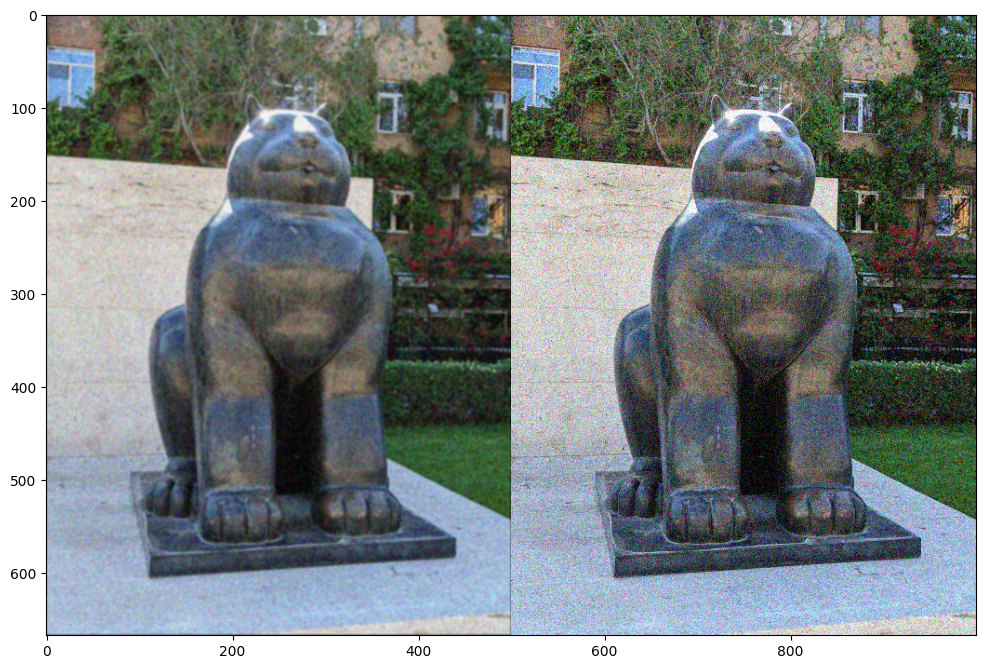

In [ ]:
# Apply filter to image
img_blur = color_convolution(img_noised, kernel_gauss)
plt.figure(figsize = (12,10))
plt.imshow(np.hstack((img_blur, img_noised)))

In [ ]:
# Sharpening filter values
kernel_sharpen = np.array(
    [[-1, -1, -1, -1, -1],
     [-1, -1, -1, -1, -1],
     [-1, -1, 50, -1, -1],
     [-1, -1, -1, -1, -1],
     [-1, -1, -1, -1, -1]],
    dtype=np.float32
)

kernel_sharpen /= np.sum(kernel_sharpen)
kernel_sharpen

array([[-0.03846154, -0.03846154, -0.03846154, -0.03846154, -0.03846154],
       [-0.03846154, -0.03846154, -0.03846154, -0.03846154, -0.03846154],
       [-0.03846154, -0.03846154,  1.9230769 , -0.03846154, -0.03846154],
       [-0.03846154, -0.03846154, -0.03846154, -0.03846154, -0.03846154],
       [-0.03846154, -0.03846154, -0.03846154, -0.03846154, -0.03846154]],
      dtype=float32)

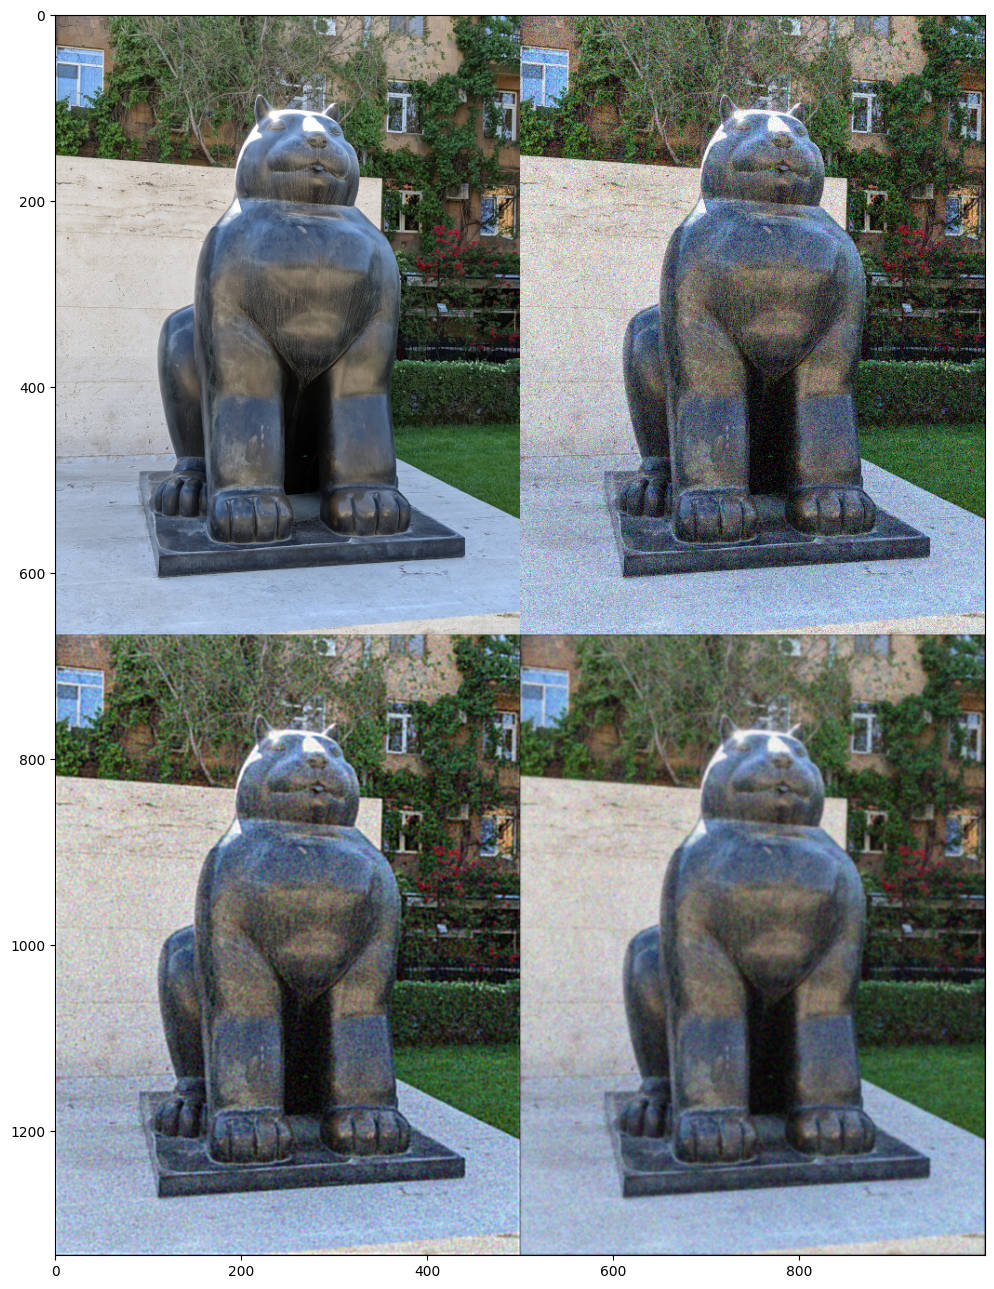

In [ ]:
# Apply sharpen filters to image
img_restored = color_convolution(img_blur, kernel_sharpen)
plt.figure(figsize = (12,20))
plt.imshow(np.vstack(
    (np.hstack((img, img_noised)),
    np.hstack((img_restored, img_blur)))
))

In [ ]:
# Saving an image from NumPy array
image_modified = img_as_ubyte(img_restored)
imsave('The_Cat_modified.jpg', arr=image_modified)

### Image Processing in JAX

In [ ]:
## NumPy
import numpy as np

## JAX
import jax.numpy as jnp
from jax.scipy.signal import convolve2d

In [ ]:
# Matrix or Kernel for Simple blur in JAX
kernel_blur = jnp.ones((5,5))
kernel_blur /= jnp.sum(kernel_blur)
kernel_blur

Array([[0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04]], dtype=float32)

In [ ]:
type(kernel_blur)

jaxlib.xla_extension.ArrayImpl

In [ ]:
import numpy as np
import jax.numpy as jnp

np.array([1, 42, 31337])

array([    1,    42, 31337])

In [ ]:
jnp.array([1, 42, 31337])

Array([    1,    42, 31337], dtype=int32)

In [ ]:
np.sum([1, 42, 31337])

31380

In [ ]:
try:
  jnp.sum([1, 42, 31337])
except TypeError as e:
  print(e)

sum requires ndarray or scalar arguments, got <class 'list'> at position 0.


In [ ]:
jnp.sum(jnp.array([1, 42, 31337]))

Array(31380, dtype=int32)

In [ ]:
# List of peroperties for JAX Array
arr = jnp.array([1, 42, 31337])
print(f"Sample JAX array: {arr}\n")
print(f"Dimension of sample array: {arr.ndim}\n")
print(f"Shape of sample array: {arr.shape}\n")
print(f"Data Type of sample array: {arr.dtype}\n")
print(f"Size of sample array: {arr.size}\n")
print(f"Memory size of sample array: {arr.nbytes}")

Sample JAX array: [    1    42 31337]

Dimension of sample array: 1

Shape of sample array: (3,)

Data Type of sample array: int32

Size of sample array: 3

Memory size of sample array: 12


## Devices in JAX

In [ ]:
import jax
print(f"Devices present: {jax.devices()}")
print(f"Local devices present: {jax.local_devices()}")
print(f"CPU Devices present: {jax.devices('cpu')}")
print(f"Number of gpu devices present: {jax.device_count('gpu')}")

Devices present: [cuda(id=0)]
Local devices present: [cuda(id=0)]
CPU Devices present: [CpuDevice(id=0)]
Number of gpu devices present: 1


In [ ]:
import jax.numpy as jnp
arr = jnp.array([1, 42, 31337])
arr.devices()

{cuda(id=0)}

In [ ]:
arr_cpu = jax.device_put(arr, jax.devices('cpu')[0])
arr_cpu.devices()

{CpuDevice(id=0)}

In [ ]:
# Calling a binary operation on uncommitted and committed tensors on different devices(OK)
arr + arr_cpu

Array([    2,    84, 62674], dtype=int32)

In [ ]:
arr_gpu = jax.device_put(arr, jax.devices('gpu')[0])
try:
  arr_gpu + arr_cpu
except ValueError as e:
  print(e)

Received incompatible devices for jitted computation. Got argument x1 of jax.numpy.add with shape int32[3] and device ids [0] on platform GPU and argument x2 of jax.numpy.add with shape int32[3] and device ids [0] on platform CPU


### Asynchronous dispatch

In [ ]:
a = jnp.array(range(1000000)).reshape((1000,1000))
a.devices()

{cuda(id=0)}

In [ ]:
%time x = jnp.dot(a,a)

CPU times: user 23.8 ms, sys: 5.16 ms, total: 28.9 ms
Wall time: 168 ms


In [ ]:
%time x = jnp.dot(a,a).block_until_ready()

CPU times: user 1.3 ms, sys: 72 µs, total: 1.37 ms
Wall time: 8.07 ms


In [ ]:
a_cpu = jax.device_put(a, jax.devices('cpu')[0])
a_cpu.devices()

{CpuDevice(id=0)}

In [ ]:
%time x = jnp.dot(a_cpu,a_cpu).block_until_ready()

CPU times: user 241 ms, sys: 4.92 ms, total: 246 ms
Wall time: 218 ms
